# Exercise 1 - Calculate $\pi$

Using the **DSMC method**, calculate the value of **$\pi$**.


**Approach:**
In order to do this, create a 2-dimensional domain (defined by the coordinates $x_{min}, x_{max}, y_{min}, y_{max}$) and launch a number P of particles at random locations within. Check which particles lie inside a circle with radius $$ \frac{x_{max}-x_{min}}{2}, $$ where $x_{min}, x_{max}$ are the x-limits of your 2D domain. 

Get your value for $\pi$ by using the following formula:
$\pi = \frac{4 \cdot n_{inside}}{P},$ where $n_{inside}$ is the number of particles inside the circle and $P$ is the total number of particles.

**a)** Play around with the number of particles and plot your calculated value as a function of this number. 

**b)** Also plot the difference between the value you obtained for $\pi$ and the real one (as a function of P). 

**c)** Make a plot for your domain, highlighting the particles that are inside the circle.

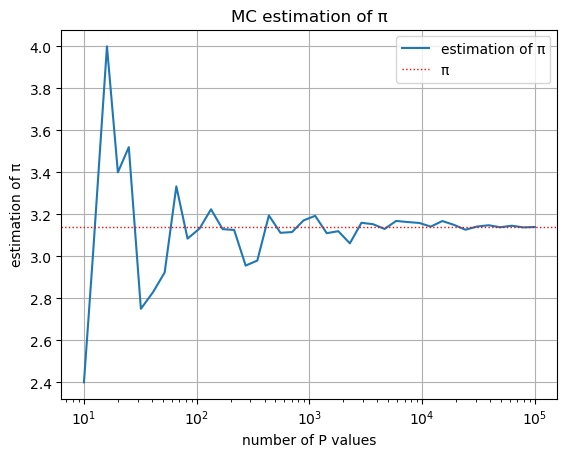

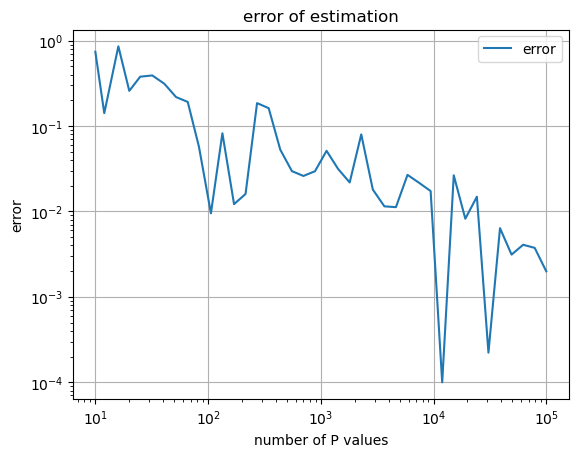

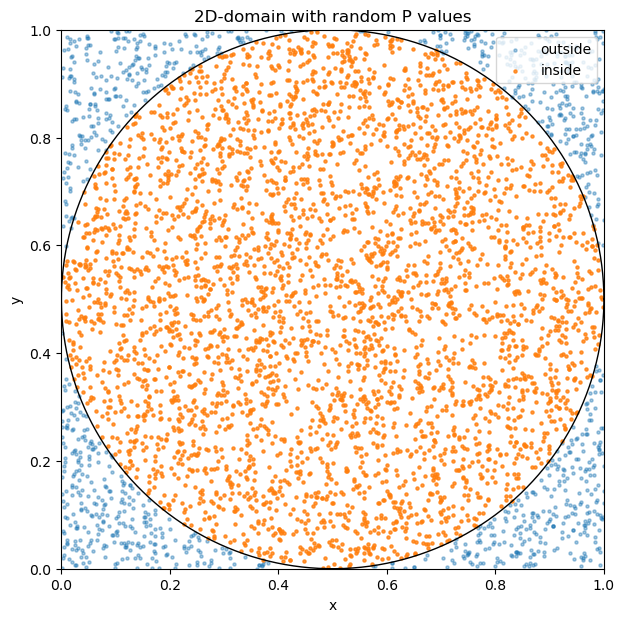

In [26]:
import numpy as np
import matplotlib.pyplot as plt

xmin, xmax= 0.0, 1.0
ymin, ymax= 0.0, 1.0

centerX= ( xmax - xmin ) / 2
centerY= ( ymax - ymin ) / 2
R=       ( xmax - xmin ) / 2

np.random.seed( 8325876 )


def myPi( P ):
  x= np.random.uniform( xmin, xmax, P )
  y= np.random.uniform( ymin, ymax, P )

  inside= (x - centerX)**2 + (y - centerY)**2 <= R**2
  n_inside= inside.sum()

  pi_est= ( 4.0 * n_inside ) / P
  pi_err= abs( np.pi - pi_est )

  return pi_est, pi_err


P_values= np.unique( np.logspace( 1 , 5, 40, dtype=int ) )
pi_values= []
errors= []

for P in P_values:
  pi_est, pi_err= myPi( P )
  pi_values.append( pi_est )
  errors.append( pi_err )

pi_values= np.array( pi_values )
errors= np.array( errors )


plt.plot( P_values, pi_values, label='estimation of π' )
plt.axhline( np.pi, color='red', linewidth=1, linestyle=':', label='π' )
plt.xscale( 'log' )
plt.xlabel( 'number of P values' )
plt.ylabel( 'estimation of π' )
plt.title( 'MC estimation of π' )
plt.legend()
plt.grid( True )
plt.show()


plt.plot( P_values, errors, label='error' )
plt.xscale( 'log' )
plt.yscale( 'log' )
plt.xlabel( 'number of P values' )
plt.ylabel( 'error' )
plt.title( 'error of estimation' )
plt.legend()
plt.grid( True )
plt.show()


P_scatter = 5000
x= np.random.uniform( xmin, xmax, P_scatter )
y= np.random.uniform( ymin, ymax, P_scatter )
pointsIn= (x - centerX)**2 + (y - centerY)**2 <= R**2

plt.figure( figsize=(7,7) )
plt.scatter( x[~pointsIn], y[~pointsIn], s=5, alpha=0.4, label='outside' )
plt.scatter( x[pointsIn],  y[pointsIn],  s=5, alpha=0.8, label='inside' )

angle= np.linspace( 0, 2*np.pi, 400 )
xc= centerX + R*np.cos( angle )
yc= centerY + R*np.sin( angle )
plt.plot( xc, yc, color='black', linewidth=1 )
plt.xlim( xmin, xmax )
plt.ylim( ymin, ymax )
plt.title( '2D-domain with random P values' )
plt.xlabel( 'x' )
plt.ylabel( 'y' )
plt.legend( loc='upper right' )
plt.show()

#EOF

# Exercise 2 - Metropolis-Hastings

Using the Metropolis-Hastings algorithm, find the standard deviation $\sigma$ and mean value $\mu$ of a random Gaussian distribution. The data to be used for this exercise can be found in the file 'input_data.txt'.

**Approach (i.e. how the Metropolis-Hastings algorithm looks like):** Start with an initial guess for your standard deviation and mean (you can use the built-in numpy functions for this). 

Generate new values by adding some random noise to the previous/initial guess. Get the noise from a probability distribution. Use for example a Gaussian distribution which you can get via the function

In [27]:
from scipy.stats import norm
# norm(parameter, sigma_m).rvs()

from the scipy.stats package, where $sigma_m$ is the average step size. One can assume a value of 0.1 for this, or play around with this parameter and see what happens. Make sure your sigma isn't lower than zero, otherwise you will end up with NaNs or other weird values.

Compute the likelihood of your new values. Remember the likelihood formula from the lecture and apply it to your points. Compare the likelihood of the new and old values and accept the most relevant value. 

**Note:** Should the likelihood of your new value be lower than the older one, you can use the _acceptance-rejection criterion_ to determine which one to keep (see lecture slides and use a random _r_ value between 0 and 1).

Repeat until you converge on a value (ideally the same one as the values computed with the built-in functions).

For the following plots make sure to include the true values as well, i.e. overplot $\sigma$ and $\mu$ where relevant.

**a)** Plot $\mu$ as a function of the number of iterations.

**b)** Plot $\sigma$ as a function of the number of iterations.

**c)** Make a plot of the dataset you were given and overplot your best fit.

**d)** [OPTIONAL] Please repeat **a)**, **b)**, and **c)**, but this time use the emcee package discussed in Exercise Sheet 8. Do you get the same result as with your own implementation of an MCMC sampler? What is the difference between the sampler implemented by the emcee package and the Metropolis-Hastings algorithm?

numpy estimates:
µ= 6.713
σ= 15.697
acceptance rate= 0.945
MCMC mean(µ)=6.863
MCMC mean(σ)=15.926


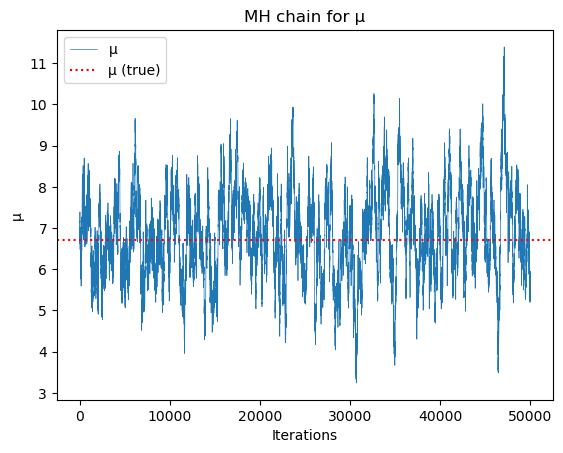

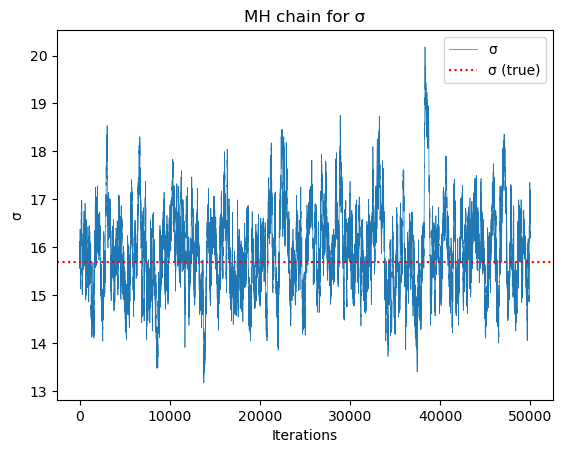

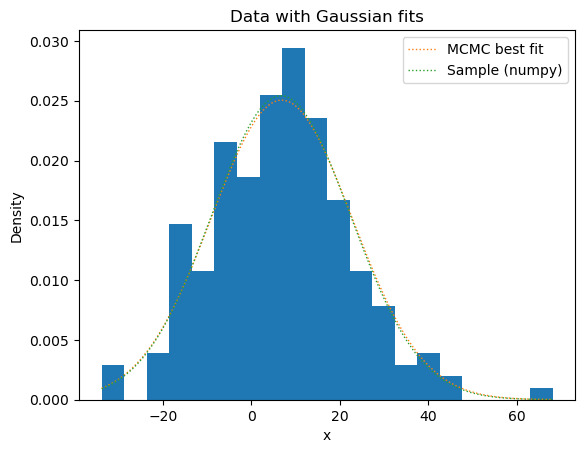

In [33]:

data= np.loadtxt( 'input_data_9.txt' ) # renamed because of name conflict with file from exercise 8

mu_true= np.mean( data )               # numpy estimates as starting values
sigma_true= np.std( data, ddof=1 )

print( 'numpy estimates:' )
print( f'µ= {mu_true:.3f}' )
print( f'σ= {sigma_true:.3f}' )


def log_likelihood( mu, sigma, x ):
  if sigma <= 0:
    return -np.inf
  return -0.5 * np.sum( ( ( x - mu ) / sigma )**2 + np.log( 2 * np.pi * sigma**2 ) )

N= 50000
mu_chain= np.zeros( N )
sigma_chain= np.zeros( N )

mu_chain[0]= mu_true
sigma_chain[0]= sigma_true

sigma_m= 0.1  # proposal step size

current_log_like= log_likelihood( mu_chain[0], sigma_chain[0], data )

accepts= 0

for i in range( 1, N ):
  mu_prop= norm( mu_chain[i-1], sigma_m ).rvs()
  sigma_prop= norm( sigma_chain[i-1], sigma_m ).rvs()

  if sigma_prop <= 0:
    mu_chain[i]= mu_chain[i-1]
    sigma_chain[i]= sigma_chain[i-1]
    continue

  prop_log_like= log_likelihood( mu_prop, sigma_prop, data )

  log_alpha= prop_log_like - current_log_like

  if np.log( np.random.rand() ) < log_alpha:  # accept
    mu_chain[i]= mu_prop
    sigma_chain[i]= sigma_prop
    current_log_like= prop_log_like
    accepts+= 1
  else:                                       # reject
    mu_chain[i]= mu_chain[i-1]
    sigma_chain[i]= sigma_chain[i-1]

accept_rate= accepts / ( N - 1 )
print( f'acceptance rate= {accept_rate:.3f}' )


burn_in= 5000
mu_mcmc= np.mean( mu_chain[burn_in:] )
sigma_mcmc= np.mean( sigma_chain[burn_in:] )

print( f'MCMC mean(µ)={mu_mcmc:.3f}' )
print( f'MCMC mean(σ)={sigma_mcmc:.3f}' )


plt.plot( mu_chain, linewidth=0.5, label='µ' )
plt.axhline( mu_true, linestyle=':', color='red', label='µ (true)' )
plt.xlabel( 'Iterations' )
plt.ylabel( 'µ' )
plt.title( 'MH chain for µ' )
plt.legend()
plt.show()

plt.plot( sigma_chain, linewidth=0.5, label='σ' )
plt.axhline( sigma_true, linestyle=':', color='red', label='σ (true)' )
plt.xlabel( 'Iterations' )
plt.ylabel( 'σ' )
plt.title( 'MH chain for σ' )
plt.legend()
plt.show()

def gauss_pdf( x, mu, sigma ):
  return 1 / ( np.sqrt( 2 * np.pi ) * sigma ) * np.exp( -0.5 * ( ( x - mu ) / sigma )**2 )

x_grid= np.linspace( np.min(data), np.max(data), 500 )

plt.hist( data, bins=20, density=True )
plt.plot( x_grid, gauss_pdf( x_grid, mu_mcmc, sigma_mcmc ), linestyle=':', linewidth=1, label='MCMC best fit' )
plt.plot( x_grid, gauss_pdf( x_grid, mu_true, sigma_true ), linestyle=':', linewidth=1, label='Sample (numpy)' )
plt.xlabel( 'x' )
plt.ylabel( 'Density' )
plt.title( 'Data with Gaussian fits' )
plt.legend()
plt.show()
